# XAI MODEL BUILD

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split

# Load Train and Test Datasets

In [2]:
df_train = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/train.csv')
df_test = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/test.csv')

In [3]:
X_train = df_train.drop(['label'], axis=1)  # Features
y_train = df_train['label']  # Target variable

In [4]:
X_test = df_test.drop(['label'], axis=1)  # Features
y_test = df_test['label']  # Target variable

# Load Model

In [5]:
# load the trained model to a specific folder
model_folder = "../../../3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_RandomForest.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

# Feature Importance

In [6]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

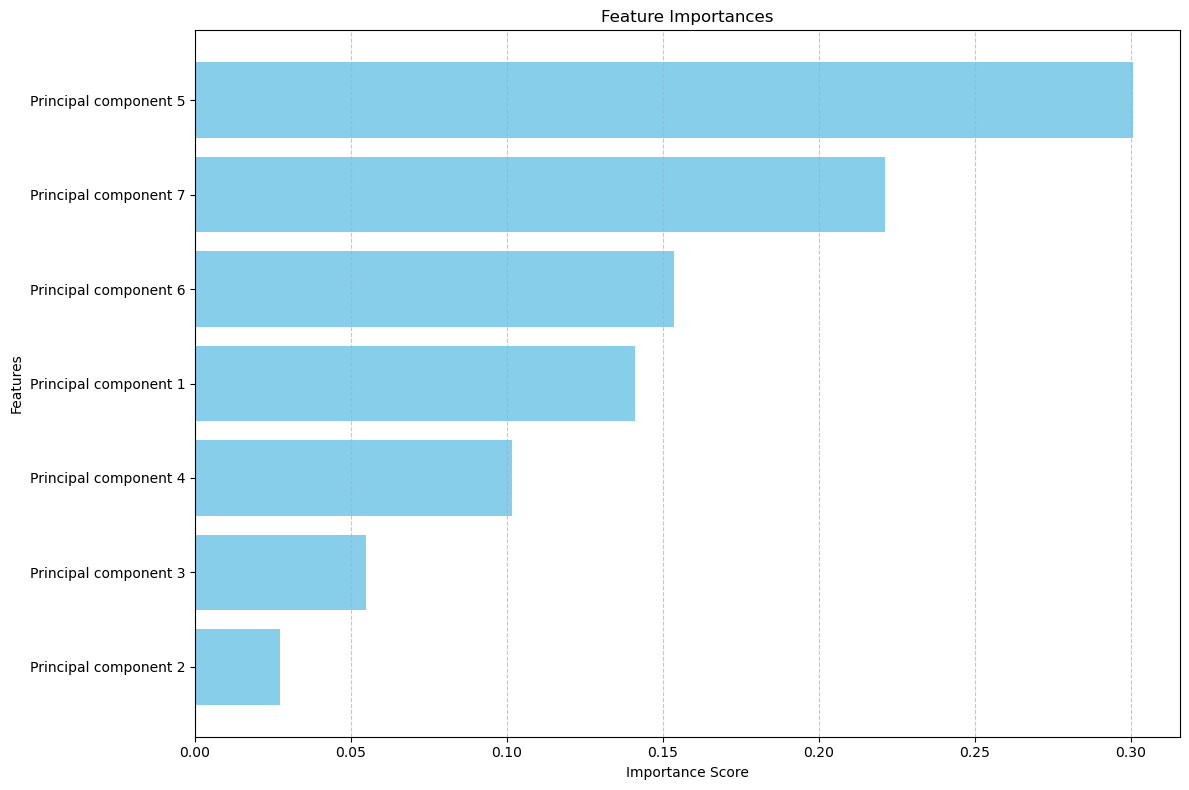

In [7]:
# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar plot
ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

# Set y-axis labels
ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

# Set title and labels
ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

# Invert y-axis for better readability
ax.invert_yaxis()

# Add grid for better visualization
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()



In [8]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: user 60.1 ms, sys: 11.7 ms, total: 71.8 ms
Wall time: 65.1 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,Principal component 5,4,0.300631,1.000000
1,Principal component 7,6,0.221193,0.857143
2,Principal component 6,5,0.153596,0.714286
3,Principal component 1,0,0.140929,0.571429
4,Principal component 4,3,0.101606,0.428571
5,Principal component 3,2,0.054712,0.285714
6,Principal component 2,1,0.027333,0.142857


# SHAP Interpretability

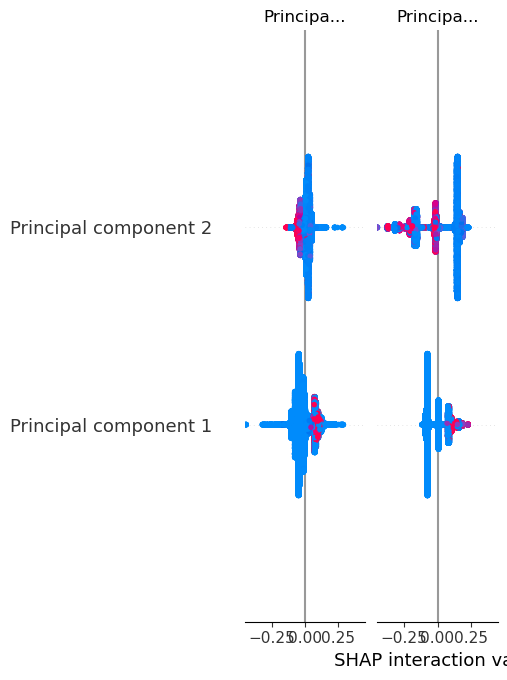

CPU times: user 5min 36s, sys: 1.24 s, total: 5min 37s
Wall time: 5min 37s


In [9]:
import shap

def visualize_shap_summary_plot(model, X_test, feature_names=None, class_names=None):
    """
    Visualize SHAP summary plot for interpreting model predictions.
    """
    # Create a SHAP explainer for the model
    explainer = shap.TreeExplainer(model)  

    # Calculate SHAP values for the test dataset
    shap_values = explainer.shap_values(X_test)

    # Visualize the SHAP summary plot
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names)

%time visualize_shap_summary_plot(model, X_test, feature_names=feature_names, class_names=['Normal', 'Malicious'])

# InterpretML

In [10]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test,feature_names=feature_names)

show(msa.explain_global())

CPU times: user 1.57 s, sys: 141 ms, total: 1.71 s
Wall time: 644 ms


<!-- http://127.0.0.1:7484/5478711952/ -->

# LOFO

In [11]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    # Validate inputs
    if target_column not in df.columns:
        raise KeyError(f"The target column '{target_column}' is missing from the DataFrame.")
    
    missing_features = [f for f in feature_names if f not in df.columns]
    if missing_features:
        raise KeyError(f"The following features are missing from the DataFrame: {missing_features}")

    if df.empty:
        raise ValueError("The DataFrame is empty.")
    
    # Cross-validation scheme
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None)

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    return importance

# Ensure feature names exclude the target column
feature_names = [col for col in df_test.columns if col != "label"]

# Calculate LOFO importance
%time importance = calculate_lofo_importance(df=df_test, target_column="label", feature_names=feature_names)

print(importance)


[LightGBM] [Info] Number of positive: 9017, number of negative: 12439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 21456, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420255 -> initscore=-0.321725
[LightGBM] [Info] Start training from score -0.321725
[LightGBM] [Info] Number of positive: 12033, number of negative: 9424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560796 -> initscore=0.244393
[LightGBM] [Info] Start training from score 0.244393
[LightGBM] [Info] 

  0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 9017, number of negative: 12439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 21456, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.420255 -> initscore=-0.321725
[LightGBM] [Info] Start training from score -0.321725
[LightGBM] [Info] Number of positive: 12033, number of negative: 9424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560796 -> initscore=0.244393
[LightGBM] [Info] Start training from score 0.244393
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 12033, number of negative: 9424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560796 -> initscore=0.244393
[LightGBM] [Info] Start training from score 0.244393
[LightGBM] [Info] Number of positive: 10710, number of negative: 10747
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 21457, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499138 -> initscore=-0.003449
[LightGBM] [Info] Start training from score -0.003449
[LightGBM] [Info]

In [12]:
import time
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np

def explain_with_lime(model, X_test, feature_names, instance_index=0, class_names=None):
    """
    Use LIME to explain a prediction from the model.
    
    Parameters:
    - model: Trained model to explain.
    - X_test: Test dataset (features only).
    - feature_names: List of feature names.
    - instance_index: Index of the instance to explain.
    - class_names: Names of the classes (optional, for classification tasks).
    """
    # Initialize LIME explainer
    explainer = LimeTabularExplainer(
        X_test.values,  # Data as a numpy array
        mode="classification",  # Use "regression" for regression tasks
        feature_names=feature_names,
        class_names=class_names,
        discretize_continuous=True  # Discretize continuous variables
    )

    # Choose the instance to explain
    instance = X_test.iloc[instance_index].values.reshape(1, -1)
    
     
    # Measure timing
    cpu_start = time.process_time()  # Start CPU time
    wall_start = time.time() 
    
    # Generate explanation
    explanation = explainer.explain_instance(
        instance.flatten(),
        model.predict_proba,  # Probability prediction method
        num_features=len(feature_names)  # Number of features to include in the explanation
    )
    
    
     # Measure timing
    cpu_end = time.process_time()  # End CPU time
    wall_end = time.time()         # End wall time

    # Calculate time
    cpu_time = cpu_end - cpu_start
    wall_time = wall_end - wall_start

    # Print timing information
    print(f"CPU Time: {cpu_time:.4f} seconds")
    print(f"Wall Time: {wall_time:.4f} seconds")
    
    # Display the explanation as a bar chart
    explanation.show_in_notebook(show_table=True)
    
    # Save visualization
    fig = explanation.as_pyplot_figure()
    plt.title(f"Instance {instance_index} Explanation")
    plt.show()

CPU Time: 0.8144 seconds
Wall Time: 0.1568 seconds


/Users/mohammedabdulai/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



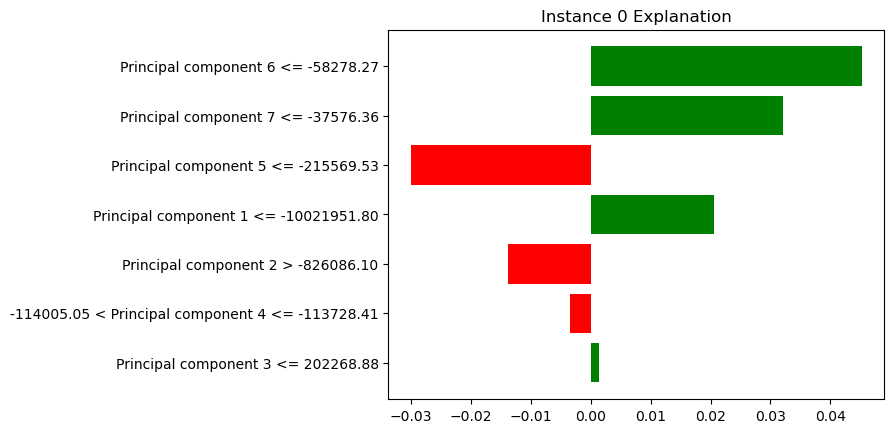

In [13]:
# Ensure X_test only contains feature columns (exclude the target column)
explain_with_lime(model, X_test, feature_names=feature_names, instance_index=0, class_names=["Normal", "Malicious"])